In [1]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import gradio as gr
import datetime
import logging
import asyncio
import uuid
import json
import os

In [2]:
class SmartJSONFormatter(logging.Formatter):
    def format(self, record):
        base = f"{self.formatTime(record)} - {record.name} - {record.levelname}"
        msg = record.msg
        try:
            if isinstance(msg, dict):
                return f"{base} - JSON payload:\n{json.dumps(msg, indent=2, default=str)}"
            if isinstance(msg, str) and msg.strip().startswith(("{", "[")):
                parsed = json.loads(msg)
                return f"{base} - JSON payload:\n{json.dumps(parsed, indent=2, default=str)}"
        except Exception as e:
            logger.warning(f"Failed to serialize log message as JSON: {e}")
        return f"{base} - {record.getMessage()}"


# Configure logging with File + Console
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.FileHandler("sidekick_clean.log"),
        logging.StreamHandler()
    ]
)

# Apply formatter to all handlers
formatter = SmartJSONFormatter()
for handler in logging.getLogger().handlers:
    handler.setFormatter(formatter)

logger = logging.getLogger(__name__)


In [3]:
# Load environment variables
logger.info("Loading environment variables")
load_dotenv(override=True)

2025-08-22 14:35:45,568 - __main__ - INFO - Loading environment variables


True

In [4]:
# Initialize LLMs
google_api_key = os.getenv("GOOGLE_API_KEY")
logger.info("Initializing Google Generative AI models")
llm_1 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
llm_2 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)

2025-08-22 14:35:45,653 - __main__ - INFO - Initializing Google Generative AI models


In [5]:
# Define structured output
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")

In [ ]:
# Define state
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

In [7]:
# Initialize Playwright browser
logger.info("Initializing Playwright browser")
import nest_asyncio
nest_asyncio.apply()
async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

2025-08-22 14:35:45,891 - __main__ - INFO - Initializing Playwright browser


In [8]:
# Initialize LLMs with tools and structured output
logger.info("Binding tools to worker LLM and setting up evaluator with structured output")
worker_llm = llm_1
worker_llm_with_tools = worker_llm.bind_tools(tools)
evaluator_llm = llm_2
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

2025-08-22 14:35:50,738 - __main__ - INFO - Binding tools to worker LLM and setting up evaluator with structured output


In [ ]:
def worker(state: State) -> Dict[str, Any]:
    logger.info("Entering worker node")
    logger.info(state)
    logger.info(f"Input state messages:")
    logger.info({"messages": [msg.dict() for msg in state['messages']]})
    
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
    You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
    This is the success criteria:
    {state['success_criteria']}
    You should reply either with a question for the user about this assignment, or with your final response.
    If you have a question for the user, you need to reply by clearly stating your question. An example might be:

    Question: please clarify whether you want a summary or a detailed answer

    If you have finished, reply with the final answer, and do not ask a question; simply reply with the answer.
    """
    
    if state.get("feedback"):
        logger.info("Incorporating feedback:")
        logger.info(state['feedback'])
        system_message += f"""
    Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
    Here is the feedback on why this was rejected:
    {state['feedback']}
    With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    
    # Manage system message in conversation
    found_system_message = False
    messages = state["messages"]
    logger.info("Processing messages: ")
    logger.info({"messages": [msg.dict() for msg in state['messages']]})
    for message in messages:
        if isinstance(message, SystemMessage):
            logger.info("Updating existing system message")
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        logger.info("Adding new system message")
        messages = [SystemMessage(content=system_message)] + messages
    
    logger.info(f"Messages after system message handling: ")
    logger.info({"messages": [msg.dict() for msg in state['messages']]})  
    # -- logger.info({"messages": [msg.dict() for msg in messages]}) 
    # The method "dict" in class "BaseModel" is deprecated The `dict` method is deprecated; use `model_dump` instead , this does not pops up on state['messages'] as state is of type typedDict and not basemodel, on the other hand, on doing previous comment, it says this thing, as in langchain messages inhertis basemodel, and messages are type of SystemMessage
    # Invoke the LLM with tools
    logger.info("Invoking worker LLM")
    response = worker_llm_with_tools.invoke(messages)
    # the response will also be having an id, that is not from Gemini. It’s generated by LangChain when it wraps the provider’s response into an AIMessage. id format: run--<uuid>-<index>, id: run--33dbfc94-3b2e-4247-8d8d-4005219b7f70-0
    logger.info("Worker LLM response:")
    # logging data with str() calls the __repr__ of the object, so it will show some subset of the field, which will not include some of the field, it is developer friendly and easy to read, compacted
    logger.info(str(response))
    
    # Log message addition to state
    logger.info("Adding worker response to state messages")
    new_state = {
        "messages": [response],
        
    }
    
    # logger.info(f"Exiting worker node with state: {n}")
    logger.info(f"Output state messages: ")
    logger.info({"messages": [msg.model_dump() for msg in new_state['messages']]})
    # by logging he informatio using the msg.model_dump() it shows all of the variables, comes from Pydantic’s BaseModel (LangChain’s messages are Pydantic models)
    # Unlike __repr__, .model_dump() serializes all fields in the model, including defaults and optional ones
        #Every LangChain message class has a type:
        # HumanMessage → type="human"
        # AIMessage → type="ai"
        # SystemMessage → type="system"
    # here, one thing to observe is, i never used the AIMessage to wrap the response, but it did assigned the response coming from llm as type ai, as in langchain, The LLM call always wraps its response inside an AIMessage, That’s how LangChain knows "type": "ai" → even if you never touched the constructor
    return new_state


In [10]:
def worker_router(state: State) -> str:
    logger.info("Entering worker router")
    last_message = state["messages"][-1]
    logger.info("Last message in state:")
    logger.info(str(last_message))
    # logger.info({str(last_message)})
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        logger.info(f"Routing to tools node due to tool calls: {last_message.tool_calls}")
        return "tools"
    else:
        logger.info("Routing to evaluator node")
        return "evaluator"

In [11]:
def format_conversation(messages: List[Any]) -> str:
    logger.info("Formatting conversation history")
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
            # logger.info(f"Formatted user message: {message.content}")
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
            # logger.info(f"Formatted assistant message: {text}")
        elif isinstance(message, SystemMessage):
            conversation += f"System: {message.content}\n"
            # logger.info(f"Formatted system message: {message.content}")
    logger.info(f"Full formatted conversation: ")
    logger.info(conversation)
    return conversation

In [ ]:
def evaluator(state: State) -> State:
    logger.info(f"\nEntering evaluator node")
    logger.info(state)
    last_response = state["messages"][-1].content
    logger.info(f"Evaluating last response:")
    logger.info({last_response})
    logger.info(f"Current state messages:")
    logger.info({"messages": [msg.dict() for msg in state['messages']]})
    
    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
    Assess of the Assistant last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
    and whether more input is needed from the user."""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

    The entire conversation with the assistant, with the original request of the user and all replies, are:
    {format_conversation(state['messages'])}

    The success criteria for this assignment is:
    {state['success_criteria']}

    And the final response from the Assistant that you are evaluating is:
    {last_response}

    Respond with your feedback, and decide if the success criteria is met by this response.
    Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
    """
    if state["feedback"]:
        logger.info("Adding previous feedback to evaluation:")
        logger.info(state['feedback'])
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback']}\n"
        user_message += "If you are seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    logger.info("Evaluator input messages:")
    # logger.info([str(msg) for msg in evaluator_messages])
    logger.info({"messages": [msg.dict() for msg in state['messages']]})
    
    logger.info("Invoking evaluator LLM")
    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    # -- here print eval_result 
    # -- reaplce simple logs with model.dumps or .dict()
    logger.info(f"Evaluator result: feedback={eval_result.feedback}, success_criteria_met={eval_result.success_criteria_met}, user_input_needed={eval_result.user_input_needed}")
    
    new_state = {
        "messages": [{"role": "assistant", "content": f"Evaluator Feedback on this answer: {eval_result.feedback}"}],
        "feedback": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    
    logger.info("Adding evaluator feedback to state messages")
    # logger.info("New state messages")
    # logger.info(new_state['messages'])
    # logger.info(new_state['messages'])
    logger.info(f"New state: ")
    logger.info(new_state)
    return new_state

In [13]:
def route_based_on_evaluation(state: State) -> str:
    logger.info("Entering evaluation router")
    logger.info(f"State for routing: success_criteria_met={state['success_criteria_met']}, user_input_needed={state['user_input_needed']}")
    logger.info(f"Current state messages: ")
    logger.info({"messages": [msg.dict() for msg in state['messages']]})
    
    if state["success_criteria_met"] or state["user_input_needed"]:
        logger.info("Routing to END due to success criteria met or user input needed")
        return END
    else:
        logger.info("Routing back to worker node")
        return "worker"

In [14]:
# Set up Graph Builder with State
logger.info("Setting up LangGraph")
graph_builder = StateGraph(State)

# Add nodes
logger.info("Adding nodes to graph")
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

# Add edges
logger.info("Adding edges to graph")
graph_builder.add_conditional_edges("worker", worker_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"worker": "worker", END: END})
graph_builder.add_edge(START, "worker")

# Compile the graph
logger.info("Compiling LangGraph with memory")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


2025-08-22 14:35:51,546 - __main__ - INFO - Setting up LangGraph
2025-08-22 14:35:51,550 - __main__ - INFO - Adding nodes to graph
2025-08-22 14:35:51,556 - __main__ - INFO - Adding edges to graph
2025-08-22 14:35:51,560 - __main__ - INFO - Compiling LangGraph with memory


In [ ]:
def make_thread_id() -> str:
    thread_id = str(uuid.uuid4())
    logger.info(f"Generated new thread ID: {thread_id}")
    return thread_id

async def process_message(message, success_criteria, history, thread):
    logger.info(f"Processing new user message: {message}")
    logger.info(f"Success criteria: {success_criteria}, Thread: {thread}")
    
    config = {"configurable": {"thread_id": thread}}
    
    state = {
        "messages": [HumanMessage(content=message)],
        # the HumanMessage constructor will make a payload out of the content provided, one of the attributes in it will be a id, of type, uuid4 that will be used to distinguish between the messages amongst the history, this can be used to deduplication upon encoutering messages with same content inside of the chat history
        # here, we have not passed id for the human message, so it is not defined in raw state, u can pass the id but it has to unqique
        # but till this point, there is not id created, as the graph with this state is not initalized yet, when graph will be invoked using this state, asynchrnously, then and then unique id of this human message will be created by langgraph, that will be handled
        "success_criteria": success_criteria,
        "feedback": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    logger.info("Initial state created")
    logger.info(f"Initial state messages: ")
    logger.info({"messages": [msg.dict() for msg in state['messages']]})
    
    logger.info("Invoking graph with initial state")
    result = await graph.ainvoke(state, config=config)
    logger.info("Graph invocation completed")
    logger.info(f"Graph result messages: ")
    logger.info({"messages": [msg.dict() for msg in state['messages']]})
    
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    
    logger.info("Preparing response for Gradio UI")
    logger.info(f"User message:")
    logger.info(user)
    logger.info(f"Assistant reply: ")
    logger.info(reply)
    logger.info(f"Evaluator feedback:")
    logger.info(feedback)
    
    logger.info("Message processing completed")
    return history + [user, reply, feedback]

In [16]:
async def reset():
    logger.info("Resetting application state")
    return "", "", None, make_thread_id()

In [ ]:
logger.info("Launching Gradio UI")
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        # chatbot = current state of the chatbot component (conversation history)
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success critiera?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    
    logger.info("Setting up Gradio event handlers")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

2025-08-22 14:35:51,836 - __main__ - INFO - Launching Gradio UI
2025-08-22 14:35:52,289 - __main__ - INFO - Generated new thread ID: a322e129-8836-44a3-b97b-437fdaf2748f
2025-08-22 14:35:52,342 - __main__ - INFO - Setting up Gradio event handlers


2025-08-22 14:35:54,820 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [ ]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7860


2025-08-22 14:35:58,136 - httpx - INFO - HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-08-22 14:35:58,207 - httpx - INFO - HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


2025-08-22 14:36:29,721 - __main__ - INFO - Processing new user message: explain about pigeon hole theorem and permuation, combination
2025-08-22 14:36:29,727 - __main__ - INFO - Success criteria: satisfactory answers, Thread: a322e129-8836-44a3-b97b-437fdaf2748f
2025-08-22 14:36:29,731 - __main__ - INFO - Initial state created
2025-08-22 14:36:29,737 - __main__ - INFO - Initial state messages: 
C:\Users\DeepDabhi\AppData\Local\Temp\ipykernel_7424\1241747390.py:21: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  logger.info({"messages": [msg.dict() for msg in state['messages']]})
2025-08-22 14:36:29,743 - __main__ - INFO - JSON payload:
{
  "messages": [
    {
      "content": "explain about pigeon hole theorem and permuation, combination",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "hu

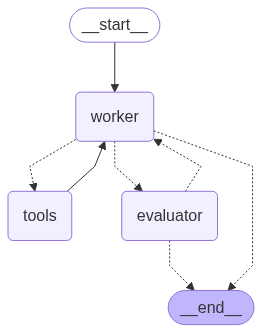

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))